Date       0
Unit       0
Minimum    0
Maximum    0
Average    0
Market     0
dtype: int64
The average price is: 9.933012472936533e-17


C:\Users\nh013\AppData\Local\Temp\ipykernel_13648\4100281644.py:46: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  mean = df.mean()
C:\Users\nh013\anaconda3\lib\site-packages\sklearn\preprocessing\_data.py:473: RuntimeWarning: All-NaN slice encountered
  data_min = np.nanmin(X, axis=0)
C:\Users\nh013\anaconda3\lib\site-packages\sklearn\preprocessing\_data.py:474: RuntimeWarning: All-NaN slice encountered
  data_max = np.nanmax(X, axis=0)
C:\Users\nh013\anaconda3\lib\site-packages\sklearn\utils\extmath.py:1047: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\nh013\anaconda3\lib\site-packages\sklearn\utils\extmath.py:1052: RuntimeWarning: invalid value encountered in divide
  T = new_sum 

Mean squared error: 0.11778494476002777
R^2 score: 0.8842633628603085
            Date Unit   Minimum   Maximum   Average  Market_Tomato  \
1     2013-06-17    0 -0.921977 -0.953164 -0.940146            0.0   
2     2013-06-18    0 -0.792841 -0.891489 -0.845290            0.0   
3     2013-06-19    0 -0.663706 -0.768138 -0.718815            0.0   
4     2013-06-20    0 -0.792841 -0.891489 -0.845290            0.0   
5     2013-06-21    0 -1.244816 -1.261540 -1.256334            0.0   
...          ...  ...       ...       ...       ...            ...   
2736  2021-05-09    0 -1.567655 -1.569916 -1.572522            0.0   
2737  2021-05-10    0 -1.567655 -1.569916 -1.572522            0.0   
2738  2021-05-11    0 -1.567655 -1.569916 -1.572522            0.0   
2739  2021-05-12    0 -0.276299 -0.336412 -0.307770            0.0   
2740  2021-05-13    0  0.046541 -0.028036  0.008418            0.0   

      Average_Lag1  
1        -0.529102  
2        -0.940146  
3        -0.845290  
4    

C:\Users\nh013\AppData\Local\Temp\ipykernel_13648\4100281644.py:124: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  print(df.corr())


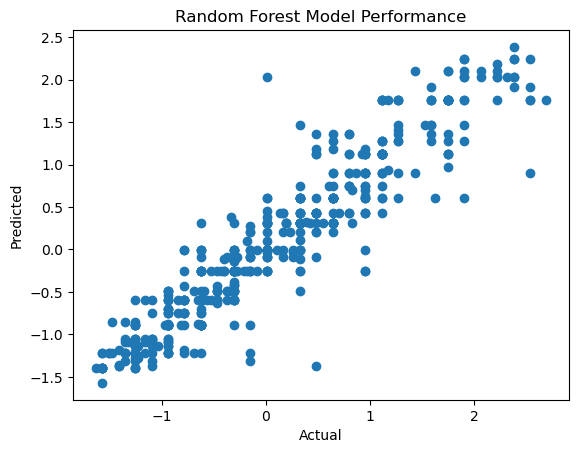

In [1]:
# TRAIN MODEL USING RANDOM FOREST

import pandas as pd
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, mean_squared_error, r2_score




 #USING FUNCTION TO HANDLE_OUTLIERS
    
def handle_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5*IQR
    upper_bound = Q3 + 1.5*IQR
    df = df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]
    return df

# CALCULATE AVERAGE PRICE

def calculate_average_price(prices):
    total = sum(prices)
    average_price = total / len(prices)
    return average_price

#DATA 
df = pd.read_csv(r'C:\Users\nh013\Desktop\tomato.csv\Tomato.csv')

# FEATURE SELECTION

df = df[['Date', 'Unit', 'Minimum','Maximum', 'Average', 'Market']]

# REPLACE 'UNKNOWN' VALUES WITH NAN VALUES IN  'UNIT' COLUMN

df['Unit'] = df['Unit'].replace('Unknown', 0)


# IDENTIFYING MISSINFG VALUES

print(df.isnull().sum())

# DROP ROWS WITH MISSING VALUES
df.dropna(inplace=True)

#FILL MISSING VALUES WITH MEAN
mean = df.mean()
df.fillna(mean, inplace=True)


#FILL MISSING VALUES WITH MODE
mode = df.mode().iloc[0]
df.fillna(mode, inplace=True)

#FILL MISSING VALUES WITH FORWARD FILL
df.fillna(method='ffill', inplace=True)


#FILL MISSING VALUES WITH  BACKWARD FILL
df.fillna(method='bfill', inplace=True)

# CONVERT UNIT COLUMN TO NUMIRECAL FORMAT  (assuming all values are in kg)

df['Unit'] = pd.to_numeric(df['Unit'].str.replace('Kg', '').str.replace(',', ''))

# HANDLE OUTLIERS
df = handle_outliers(df, 'Average')

# ONE HOT ENCODING  CATEGORICAL VARIABLE'Market'
df = pd.get_dummies(df, columns=['Market'])




# REMOVE DUOLICATE ROWS
df.drop_duplicates(inplace=True)

# NORMALIZE AND SCALING ALL NUMERICAL COLUMN
scaler = MinMaxScaler()
num_cols = df.select_dtypes(include='number').columns
df[num_cols] = scaler.fit_transform(df[num_cols])

# STANDARLIZE ALL NUMERICAL COLUMN
scaler = StandardScaler()
num_cols = df.select_dtypes(include='number').columns
df[num_cols] = scaler.fit_transform(df[num_cols])

# REPLACE 'UNKNOWN' VALUES WITH NaN VALUESin 'Unit' COLUMN
df['Unit'] = df['Unit'].replace('Unknown', 0)

# FILL NaN VALUES in Unit COLUMN with '0'
df['Unit'] = df['Unit'].fillna('0')

# CALCULATE AVERAGE PRICE
average_price = calculate_average_price(df['Average'])
print("The average price is:", average_price)

# LAG FEATURE
df['Average_Lag1'] = df['Average'].shift(1)

# Drop the first row, which will have NaN values due to the shift
df.dropna(inplace=True)

# SPLIT DATA INTO TRAING AND TESTING
X = df[['Average_Lag1']]
y = df['Average']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# MODEL
rfc = RandomForestRegressor(n_estimators=100, random_state=42)

# FIT THE MODEL
rfc.fit(X_train, y_train)

# MAKE PREDICTION ON TESTING DATA
y_pred = rfc.predict(X_test)

# EVALUATE THE MODEL PERFORMANCE
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print('Mean squared error:', mse)
print('R^2 score:', r2)


print(df)


print(df.corr())



# a scatter plot of predicted vs actual values
plt.scatter(y_test, y_pred)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Random Forest Model Performance')
plt.show()